In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
import re
import nltk

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [ ]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [ ]:
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(df):
  df['text'] = df['text'].apply(lambda x: clean_text(x))
  df = df.fillna('NaN', axis=1)
  df['text'] = 'KEYWORD= ' + df.keyword + '; LOCATION= ' + df.location + '; TEXT= ' + df.text
  df.drop(["id", "keyword", "location"], inplace=True, axis=1)
  return df

In [ ]:
df_train_processed = preprocess(df_train)
df_test_processed = preprocess(df_test)

In [ ]:
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.1

from sklearn.model_selection import train_test_split

X = df_train_processed["text"]
y = df_train_processed["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
max_length = 64
tokenized_train = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
tokenized_val = tokenizer(list(X_val), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
tokenized_test = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt", max_length=max_length)

In [ ]:
y_train = torch.tensor(list(y_train))
y_val = torch.tensor(list(y_val))

In [ ]:
train = TensorDataset(tokenized_train['input_ids'], tokenized_train['attention_mask'], y_train)
val = TensorDataset(tokenized_val['input_ids'], tokenized_val['attention_mask'], y_val)
test = TensorDataset(tokenized_test['input_ids'], tokenized_test['attention_mask'])

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, num_hidden_layers=6, hidden_size=768)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
batch_size = 16

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [ ]:
device

device(type='cuda')

In [ ]:
for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  tr_correct = 0
  for batch in train_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask = attention_mask, labels=labels)
    tr_loss = outputs.loss
    train_loss += tr_loss.item()
    tr_loss.backward()

    tr_logits = outputs.logits
    tr_preds = torch.argmax(tr_logits, dim=1)
    tr_correct += torch.sum(tr_preds == labels).item()

    clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

  scheduler.step()

  avg_train_loss = train_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  tr_accuracy = tr_correct / len(train)
  train_accuracies.append(tr_accuracy)

  model.eval()
  val_loss = 0.0
  val_correct = 0

  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, labels = batch
      input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      val_loss += loss.item()

      logits = outputs.logits
      preds = torch.argmax(logits, dim=1)
      val_correct += torch.sum(preds == labels).item()

  avg_val_loss = val_loss / len(val_loader)
  val_losses.append(avg_val_loss)

  val_accuracy = val_correct / len(val)
  val_accuracies.append(val_accuracy)

  print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Training Loss: {train_loss:.4f}, Training Accuracy: {tr_accuracy:.4f}")



Epoch 1/10, Validation Loss: 21.8067, Validation Accuracy: 0.8084, Training Loss: 215.0622, Training Accuracy: 0.7755
Epoch 2/10, Validation Loss: 24.1494, Validation Accuracy: 0.8123, Training Loss: 125.7130, Training Accuracy: 0.8876
Epoch 3/10, Validation Loss: 24.8732, Validation Accuracy: 0.8163, Training Loss: 107.7765, Training Accuracy: 0.9037
Epoch 4/10, Validation Loss: 25.2436, Validation Accuracy: 0.8163, Training Loss: 106.0015, Training Accuracy: 0.9072
Epoch 5/10, Validation Loss: 25.0542, Validation Accuracy: 0.8163, Training Loss: 105.3905, Training Accuracy: 0.9101
Epoch 6/10, Validation Loss: 25.1795, Validation Accuracy: 0.8163, Training Loss: 104.9470, Training Accuracy: 0.9115
Epoch 7/10, Validation Loss: 25.1584, Validation Accuracy: 0.8163, Training Loss: 105.8446, Training Accuracy: 0.9078
Epoch 8/10, Validation Loss: 25.2211, Validation Accuracy: 0.8163, Training Loss: 103.7490, Training Accuracy: 0.9094
Epoch 9/10, Validation Loss: 25.2050, Validation Accurac

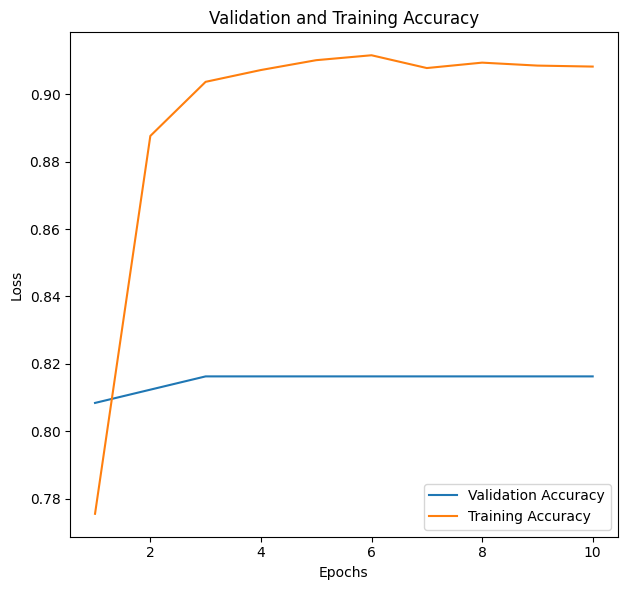

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

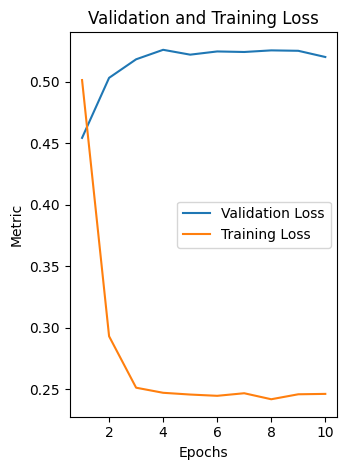

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.title('Validation and Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model after training
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
}, 'saved_model.pth')

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

In [ ]:
predicted_df = df_test.copy()

In [ ]:
predicted_df['target'] = predictions

In [ ]:
predicted_df

,id,keyword,location,text,target
0,0,NaN,NaN,happened terrible car crash,1
1,2,NaN,NaN,"heard earthquake different cities, stay safe e...",0
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st...",0
3,9,NaN,NaN,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,typhoon soudelor kills china taiwan,0
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles safety fasteners...,0
3259,10865,NaN,NaN,storm ri worse last hurricane city amp others ...,1
3260,10868,NaN,NaN,green line derailment chicago http tco utbxlcbiuy,0
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo http ...,1


In [ ]:
submission_df = pd.read_csv(f'/content/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":predictions})

In [ ]:
submission.to_csv('/content/submission.csv', index=False)